In [1]:
import numpy as np
import pandas as pd
import glob
import os
import xgboost
import csv as csv
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.model_selection import cross_val_score,KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
# from sklearn.grid_search import GridSearchCV   #Perforing grid search
from scipy.stats import skew
from collections import OrderedDict

In [2]:
dataFrame = pd.read_csv("./CombinedData.csv", header = 0, low_memory=False)
dataFrame.insert(0, 'ID', range(0,len(dataFrame)))
print(dataFrame.head())

   ID         SOLD DATE PROPERTY TYPE                  ADDRESS        CITY  \
0   0      July-28-2022   Condo/Co-op      3881 Carl Parmer Dr  Harrisburg   
1   1    August-17-2022   Condo/Co-op        6419 Town Hall Pl  Harrisburg   
2   2  February-10-2022   Condo/Co-op  1 Buffalo Ave NW Unit 7     Concord   
3   3      March-4-2022   Condo/Co-op          476 Camrose Cir     Concord   
4   4    October-8-2021   Condo/Co-op      4068 Town Center Rd  Harrisburg   

  STATE OR PROVINCE ZIP OR POSTAL CODE   PRICE  BEDS  BATHS  \
0                NC              28075  258000   3.0    2.0   
1                NC              28075  242000   3.0    2.0   
2                NC              28025  102000   2.0    1.0   
3                NC              28025  203000   2.0    1.5   
4                NC              28075  170000   2.0    1.0   

                 LOCATION  SQUARE FEET  LOT SIZE  YEAR BUILT  $/SQUARE FEET  \
0              Harrisburg       1181.0       NaN      2005.0          218

In [3]:
dataFrame = dataFrame[dataFrame['SQUARE FEET'].notna()]
dataFrame = dataFrame[dataFrame['SOLD DATE'].notna()]

In [4]:
dataFrame['SOLD DATE'] = pd.to_datetime(dataFrame['SOLD DATE']).apply(lambda x: x.value)

In [5]:
dataFrame['SQUARE FEET']

0        1181.0
1        1186.0
2         819.0
3        1188.0
4         877.0
          ...  
78909    1280.0
78928    1405.0
78929    1580.0
78957    1055.0
78961    1800.0
Name: SQUARE FEET, Length: 43869, dtype: float64

In [6]:
dataFrame['SOLD DATE']

0        1658966400000000000
1        1660694400000000000
2        1644451200000000000
3        1646352000000000000
4        1633651200000000000
                ...         
78909    1639008000000000000
78928    1636934400000000000
78929    1651708800000000000
78957    1641340800000000000
78961    1646784000000000000
Name: SOLD DATE, Length: 43869, dtype: int64

In [7]:
dataFrame = dataFrame.drop(columns=["URL (SEE https://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING)"])
dataFrame = dataFrame.drop(columns=["LOCATION"])

In [8]:
train_dataset, test_dataset = train_test_split(dataFrame, test_size=.3)
print(train_dataset.head())

          ID            SOLD DATE              PROPERTY TYPE  \
35077  35077  1654732800000000000  Single Family Residential   
40181  40181  1655424000000000000  Single Family Residential   
47536  47536  1654041600000000000  Single Family Residential   
75217  75217  1632960000000000000                  Townhouse   
371      371  1636070400000000000                Condo/Co-op   

                     ADDRESS         CITY STATE OR PROVINCE  \
35077  384 Hubert Herndon Rd  Chapel Hill                NC   
40181  14223 Fiddlers Run Dr    Charlotte                NC   
47536        300 Kingston St   Pine Level                NC   
75217        8004 Morrell Ln       Durham                NC   
371      75 Broadway St #301    Asheville                NC   

      ZIP OR POSTAL CODE    PRICE  BEDS  BATHS  SQUARE FEET  LOT SIZE  \
35077              27516   425000   3.0    2.0       1660.0   74923.0   
40181              28031   635640   5.0    3.5       3284.0   11761.0   
47536            

In [9]:
category_features = ['PROPERTY TYPE', 'CITY', 'ADDRESS', 'STATE OR PROVINCE', 'ZIP OR POSTAL CODE']
every_column_except_y = [col for col in train_dataset.columns if col not in [ 'PRICE', 'ID']]
train_dataset.describe()

,ID,SOLD DATE,PRICE,BEDS,BATHS,SQUARE FEET,LOT SIZE,YEAR BUILT,$/SQUARE FEET,HOA/MONTH,LATITUDE,LONGITUDE
count,30708.000000,3.070800e+04,3.070800e+04,30689.000000,30695.000000,30708.000000,2.891400e+04,30691.000000,30708.000000,15804.000000,30708.000000,30708.000000
mean,38868.456168,1.646067e+18,4.265116e+05,3.268663,2.447565,2077.221343,8.140997e+04,1994.163761,208.812557,104.168375,35.597360,-80.202140
std,21951.155928,9.157208e+15,2.969145e+05,0.957346,0.860683,980.031219,4.148597e+06,28.315213,364.454060,105.070460,0.300407,1.249372
min,0.000000,1.630454e+18,1.500000e+04,0.000000,0.500000,2.000000,4.300000e+01,1647.000000,14.000000,1.000000,35.016758,-82.869173
25%,20641.250000,1.638144e+18,2.780000e+05,3.000000,2.000000,1406.000000,7.405000e+03,1979.000000,161.000000,30.000000,35.348257,-80.893896
50%,40654.500000,1.646266e+18,3.670000e+05,3.000000,2.500000,1855.000000,1.350300e+04,2002.000000,193.000000,65.000000,35.576768,-80.622741
75%,55819.500000,1.654042e+18,4.850000e+05,4.000000,3.000000,2527.000000,2.744200e+04,2018.000000,233.000000,155.000000,35.847644,-78.939633
max,78961.000000,1.661990e+18,6.800000e+06,43.000000,22.000000,15800.000000,4.355564e+08,2023.000000,62500.000000,3500.000000,36.539411,-78.086563


In [10]:
non_categorical_columns = [col for col in train_dataset.columns if col not in category_features and col not in ['ID']]
numeric_features = train_dataset[non_categorical_columns].dtypes[train_dataset.dtypes != "object"].index
train_dataset[numeric_features] = np.log1p(train_dataset[numeric_features])

non_categorical_columns = [col for col in test_dataset.columns if col not in category_features and col not in ['ID']]
numeric_features = test_dataset[non_categorical_columns].dtypes[test_dataset.dtypes != "object"].index
test_dataset[numeric_features] = np.log1p(test_dataset[numeric_features])

C:\Users\Joey\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)
C:\Users\Joey\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


In [11]:
# nan_features = ['LOCATION']
# def ConvertToNAString(data, columnsList):
#     for x in columnsList:
#         data[x] = str(data[x])
# ConvertToNAString(train_dataset, nan_features)
# ConvertToNAString(test_dataset, nan_features)

In [12]:
def createColumnPerValue(data, columnsList):
  for x in columnsList:
    values = pd.unique(data[x])

    for y in values: 
      column_name = x + "_" + str(y)
      data[column_name]=(data[x]==y).astype(float)
    
    data.drop(x, axis=1, inplace=True)
    
train_dataset = pd.get_dummies(train_dataset,columns =category_features)
test_dataset = pd.get_dummies(test_dataset,columns =category_features)

In [13]:
model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 tree_method='gpu_hist',
                 gpu_id=0,
                 seed=42) 

In [14]:
train_dataset['SOLD DATE']

35077    41.950171
40181    41.950589
47536    41.949753
75217    41.936926
371      41.938829
           ...    
23789    41.938987
55837    41.942887
57079    41.935390
25088    41.951163
48556    41.939726
Name: SOLD DATE, Length: 30708, dtype: float64

In [15]:
#df['time'] = df['time'].apply(lambda x: x.value)

In [16]:
train_dataset['SQUARE FEET']

35077    7.415175
40181    8.097122
47536    7.609862
75217    7.457032
371      8.381603
           ...   
23789    6.987490
55837    8.179480
57079    7.345365
25088    7.800573
48556    7.898782
Name: SQUARE FEET, Length: 30708, dtype: float64

In [17]:
train_dataset['PRICE']

35077    12.959847
40181    13.362389
47536    12.765691
75217    12.840003
371      14.862830
           ...    
23789    12.556733
55837    13.296318
57079    12.216028
25088    13.304687
48556    13.081543
Name: PRICE, Length: 30708, dtype: float64

In [18]:
every_column_except_y= [col for col in train_dataset.columns if col not in ['PRICE','ID']]
model.fit(train_dataset[every_column_except_y],train_dataset['PRICE'])
OrderedDict(sorted(model.get_booster().get_fscore().items(), key=lambda t: t[1], reverse=True))

OrderedDict([('$/SQUARE FEET', 9171.0),
             ('SQUARE FEET', 8826.0),
             ('LOT SIZE', 6647.0),
             ('LATITUDE', 5819.0),
             ('YEAR BUILT', 5523.0),
             ('SOLD DATE', 5465.0),
             ('HOA/MONTH', 4835.0),
             ('BATHS', 4363.0),
             ('BEDS', 2574.0),
             ('PROPERTY TYPE_Single Family Residential', 802.0),
             ('CITY_Asheville', 680.0),
             ('CITY_Charlotte', 516.0),
             ('CITY_Durham', 440.0),
             ('CITY_Chapel Hill', 348.0),
             ('CITY_Mooresville', 324.0),
             ('CITY_Salisbury', 323.0),
             ('PROPERTY TYPE_Townhouse', 296.0),
             ('CITY_Gastonia', 271.0),
             ('PROPERTY TYPE_Multi-Family (2-4 Unit)', 226.0),
             ('PROPERTY TYPE_Condo/Co-op', 216.0),
             ('CITY_Statesville', 210.0),
             ('ZIP OR POSTAL CODE_28115', 202.0),
             ('CITY_Burlington', 167.0),
             ('ZIP OR POSTAL CODE_28117

In [19]:
OrderedDict(sorted(model.get_booster().get_fscore().items(), key=lambda t: t[1], reverse=True))

OrderedDict([('$/SQUARE FEET', 9171.0),
             ('SQUARE FEET', 8826.0),
             ('LOT SIZE', 6647.0),
             ('LATITUDE', 5819.0),
             ('YEAR BUILT', 5523.0),
             ('SOLD DATE', 5465.0),
             ('HOA/MONTH', 4835.0),
             ('BATHS', 4363.0),
             ('BEDS', 2574.0),
             ('PROPERTY TYPE_Single Family Residential', 802.0),
             ('CITY_Asheville', 680.0),
             ('CITY_Charlotte', 516.0),
             ('CITY_Durham', 440.0),
             ('CITY_Chapel Hill', 348.0),
             ('CITY_Mooresville', 324.0),
             ('CITY_Salisbury', 323.0),
             ('PROPERTY TYPE_Townhouse', 296.0),
             ('CITY_Gastonia', 271.0),
             ('PROPERTY TYPE_Multi-Family (2-4 Unit)', 226.0),
             ('PROPERTY TYPE_Condo/Co-op', 216.0),
             ('CITY_Statesville', 210.0),
             ('ZIP OR POSTAL CODE_28115', 202.0),
             ('CITY_Burlington', 167.0),
             ('ZIP OR POSTAL CODE_28117

In [20]:
model.save_model('model.json')

In [21]:
most_relevant_features= list(dict((k, v) for k, v in model.get_booster().get_fscore().items() if v >= 10).keys())
print(most_relevant_features)

['SOLD DATE', 'BEDS', 'BATHS', 'SQUARE FEET', 'LOT SIZE', 'YEAR BUILT', '$/SQUARE FEET', 'HOA/MONTH', 'LATITUDE', 'PROPERTY TYPE_Condo/Co-op', 'PROPERTY TYPE_Mobile/Manufactured Home', 'PROPERTY TYPE_Multi-Family (2-4 Unit)', 'PROPERTY TYPE_Multi-Family (5+ Unit)', 'PROPERTY TYPE_Single Family Residential', 'PROPERTY TYPE_Townhouse', 'CITY_Arden', 'CITY_Asheville', 'CITY_Belmont', 'CITY_Benson', 'CITY_Bessemer City', 'CITY_Black Mountain', 'CITY_Burlington', 'CITY_Candler', 'CITY_Chapel Hill', 'CITY_Charlotte', 'CITY_Cherryville', 'CITY_Clayton', 'CITY_Clemmons', 'CITY_Cleveland', 'CITY_Concord', 'CITY_Cornelius', 'CITY_Dallas', 'CITY_Davidson', 'CITY_Durham', 'CITY_Fairview', 'CITY_Fletcher', 'CITY_Four Oaks', 'CITY_Garner', 'CITY_Gastonia', 'CITY_Gold Hill', 'CITY_Graham', 'CITY_Harrisburg', 'CITY_Hillsborough', 'CITY_Huntersville', 'CITY_Kannapolis', 'CITY_Leicester', 'CITY_Lexington', 'CITY_Matthews', 'CITY_Mebane', 'CITY_Moncure', 'CITY_Mooresville', 'CITY_Olin', 'CITY_Oxford', 'C

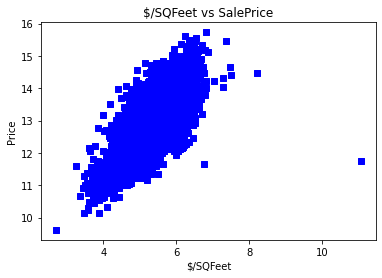

In [24]:
plt.scatter(train_dataset['$/SQUARE FEET'], train_dataset['PRICE'], c = "blue", marker = "s")
plt.title("$/SQFeet vs SalePrice")
plt.xlabel("$/SQFeet")
plt.ylabel("Price")
plt.show()